<a href="https://colab.research.google.com/github/silviolima07/Kaggle/blob/master/Classificando_o_comparecmento_em_consultas_m%C3%A9dicas_agendadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Consultas médicas no Serviço Público
- Modelo:
- Version: 1.0.0
- kaggle: https://www.kaggle.com/joniarroba/noshowappointments


![alt text](https://drive.google.com/uc?id=1_fEXKa3uoQzhcL91m0zTKhtubDavWPul))

In [0]:
# Carregando os pacotes
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import matthews_corrcoef


from scipy import stats
from sklearn.preprocessing import StandardScaler
import imblearn

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing, metrics

import warnings
warnings.filterwarnings('ignore')

import os

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [0]:
# Funcao para reducao da memoria utilizada
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
# Funcao para realizar a leitura dos arquivos
def read_data():
     
        print('Carregando os arquivos...')
        data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/KaggleV2-May-2016.csv', encoding='latin')
        data = reduce_mem_usage(data)
        print('KaggleV2-May-2016.csv tem {} linhas e {} colunas'.format(data.shape[0], data.shape[1]))
    
        return data

In [0]:
# Leitura dos dados
df = read_data()

Carregando os arquivos...
Mem. usage decreased to  5.80 Mb (50.9% reduction)
KaggleV2-May-2016.csv tem 110527 linhas e 14 colunas


In [0]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [0]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [0]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474953e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560998e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.920000e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172615e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173180e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439170e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [0]:
# Identificando o tipo das colunas
df.dtypes

PatientId         float32
AppointmentID       int32
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                  int8
Neighbourhood      object
Scholarship          int8
Hipertension         int8
Diabetes             int8
Alcoholism           int8
Handcap              int8
SMS_received         int8
No-show            object
dtype: object

In [0]:
# Colunas ScheduledDay e AppointmentDay deve ser convertidas no tipo data
df.AppointmentDay = df.AppointmentDay.apply(np.datetime64)
df.ScheduledDay = df.ScheduledDay.apply(np.datetime64)

In [0]:
# Nova coluna, o tempo de espera até a consulta
# Criada a partir da diferença de tempo entre a marcação da consulta e a data de realização
df['WaitingTime'] = pd.to_timedelta((df['AppointmentDay'] - df['ScheduledDay'])).dt.days
df['WaitingTime'] = df['WaitingTime'].apply(np.int64)

In [0]:
# O mês em que a consulta será realizada pode influenciar, pois há meses onde a pessoa tem mais compromissos: férias escolares, festas de fim de ano, clima frio ou chuvoso e outros motivos.
# Extrair o mês para o qual a consulta foi marcada
# O dia do mês também pode influenciar de acordo com o dia de pagamento da pessoa ( aposentadoria / pensão)
# Serão usados Day e Month
# Reset index
df.reset_index(inplace=True)

# Colunas Day, Month e Year
df['Day'] = df['AppointmentDay'].dt.day
df['Month'] = df['AppointmentDay'].dt.month
#df['Year'] = df['AppointmentDay'].dt.year

In [0]:
df.head()

,index,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime,Day,Month
0,0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1,29,4
1,1,5.589980e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1,29,4
2,2,4.262960e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1,29,4
3,3,8.679510e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1,29,4
4,4,8.841190e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1,29,4


In [0]:
# Remover colunas não utilizadas
df.drop(columns=['index', 'ScheduledDay','AppointmentDay','PatientId','AppointmentID'],inplace=True)

In [0]:
# Todas colunas
all_columns = np.array(df.columns)

In [0]:
all_columns

array(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'WaitingTime', 'Day', 'Month'], dtype=object)

In [0]:
# Analisando cada coluna dentro do contexto dos dados, algumas colunas são identificadas como sendo tipo int8 e na verdade seria tipo categórico.
# Separando em númerico e categórico
num_vars =np.array(['Age', "WaitingTime", "Day", "Month"])
cat_vars = np.array(['Gender', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', "Handcap",'SMS_received', 'No-show'])

In [0]:
cat_vars

array(['Gender', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='<U13')

In [0]:
# Converter para numérico e Categórico
for var in num_vars:
  df[var] = df[var].astype('int64')

for var in cat_vars:
  df[var] = df[var].astype('category')  
df.dtypes  

Gender           category
Age                 int64
Neighbourhood    category
Scholarship      category
Hipertension     category
Diabetes         category
Alcoholism       category
Handcap          category
SMS_received     category
No-show          category
WaitingTime         int64
Day                 int64
Month               int64
dtype: object

In [0]:
# Através da função describe vimos que não há dados faltantes, confirmação
df.isna().sum(axis=0)

Gender           0
Age              0
Neighbourhood    0
Scholarship      0
Hipertension     0
Diabetes         0
Alcoholism       0
Handcap          0
SMS_received     0
No-show          0
WaitingTime      0
Day              0
Month            0
dtype: int64

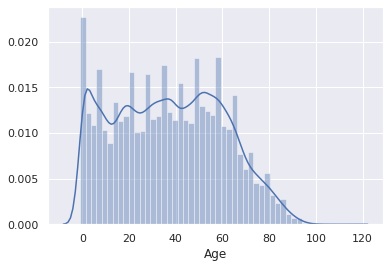

In [0]:
# Distribuição dos dados - histograma
sns.distplot(df['Age'])

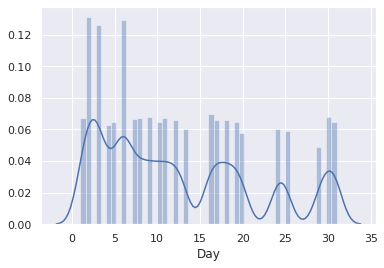

In [0]:
# Distribuição dos dados - histograma
sns.distplot(df['Day'])

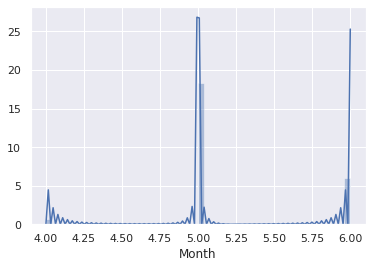

In [0]:
# Distribuição dos dados - histograma
sns.distplot(df['Month'])

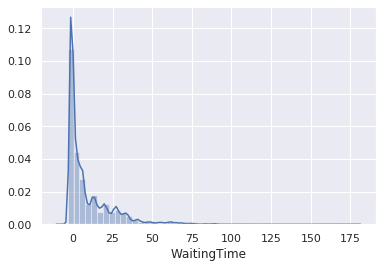

In [0]:
# Distribuição dos dados - histograma
sns.distplot(df['WaitingTime'])

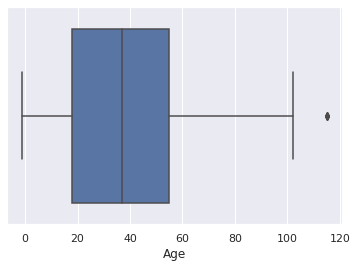

In [0]:
# Detecção de outliers
# Age
sns.boxplot(x = 'Age', data = df)

In [0]:
# Outliers esta acima de 3Z-scores de distância da média do conjunto de dados
z = np.abs(stats.zscore(df[num_vars]))

In [0]:
# Shape original com outliers
df.shape

(110527, 13)

In [0]:
df_o = df[(z < 3).all(axis=1)]

In [0]:
# Shape sem os outliers
df_o.shape

(107853, 13)

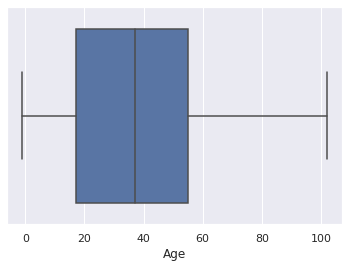

In [0]:
# Detecção de outliers
# Age
sns.boxplot(x = 'Age', data = df_o)

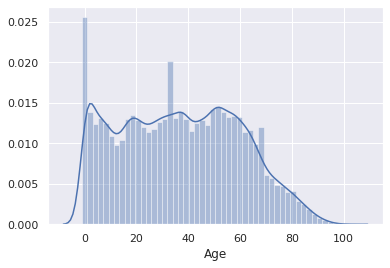

In [0]:
# Distribuição dos dados - histograma
sns.distplot(df_o['Age'])

In [0]:
# Valor de Waiting_Time de -1 deve significar atendimento no mesmo dia, portanto será convertido em zero
df_o['WaitingTime']

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
110522    34
110523    34
110524    40
110525    40
110526    40
Name: WaitingTime, Length: 107853, dtype: int64

In [0]:
# Valor de Waiting_Time vira 0

df_o['WaitingTime'] = np.where (df_o['WaitingTime'] == -1, 0, df_o['WaitingTime'])

In [0]:
df_o.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime,Day,Month
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,29,4
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,29,4
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,29,4
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,29,4
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,29,4


In [0]:
# Convertendo F = 0  e M = 1
df_o['Gender'] = df_o['Gender'].cat.codes

In [0]:
# Criando nova coluna Class e convertendo No = 0  e Yes = 1
df_o['Class'] = df_o['No-show'].cat.codes

In [0]:
df_o.dtypes

Gender               int8
Age                 int64
Neighbourhood    category
Scholarship      category
Hipertension     category
Diabetes         category
Alcoholism       category
Handcap          category
SMS_received     category
No-show          category
WaitingTime         int64
Day                 int64
Month               int64
Class                int8
dtype: object

In [0]:
# Função para preencher uma nova coluna com o sexo do paciente
# 0 - Mulher e 1 - Homem
def tipoPessoa_func(gender):
    if gender.values.item() == 1:
        return 'Homem'
    else:
        return 'Mulher' 

# Aplica a função
df_o['Sexo'] = df_o[['Gender']].apply(tipoPessoa_func, axis = 1)

In [0]:
# Função para preencher uma nova coluna com o status: compareceu ou não
# No (0)- nao compareceu e Yes (1)- compareceu
def status(no_show):
    if no_show.values.item() == 'No':
        return 'nao compareceu'
    else:
        return 'compareceu' 

# Aplica a função
df_o['Status'] = df_o[['No-show']].apply(status, axis = 1)

In [0]:
df_o.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime,Day,Month,Class,Sexo,Status
0,0,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu
1,1,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0,29,4,0,Homem,nao compareceu
2,0,62,MATA DA PRAIA,0,0,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu
3,0,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu
4,0,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0,29,4,0,Mulher,nao compareceu


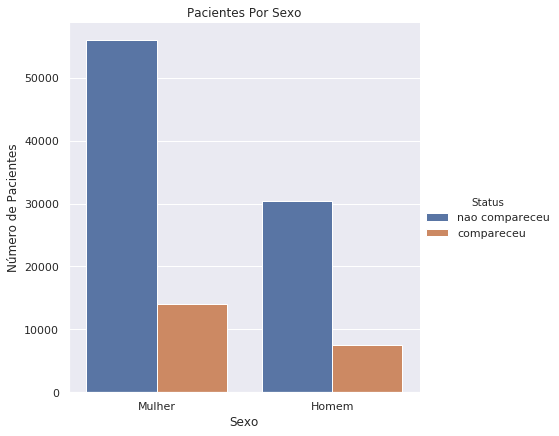

In [0]:
# Como o número de consultas é afetado pelo sexo da pessoa.
mx = sns.catplot(x = "Sexo", hue = 'Status', data = df_o, kind = "count", height = 6)
mx.set(ylabel = 'Número de Pacientes')
plt.title('Pacientes Por Sexo');

In [0]:
dataset = pd.get_dummies(df_o, columns = ['Neighbourhood'], prefix = ["N"])

In [0]:
dataset

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime,Day,Month,Class,Sexo,Status,N_AEROPORTO,N_ANDORINHAS,N_ANTÔNIO HONÓRIO,N_ARIOVALDO FAVALESSA,N_BARRO VERMELHO,N_BELA VISTA,N_BENTO FERREIRA,N_BOA VISTA,N_BONFIM,N_CARATOÍRA,N_CENTRO,N_COMDUSA,N_CONQUISTA,N_CONSOLAÇÃO,N_CRUZAMENTO,N_DA PENHA,N_DE LOURDES,N_DO CABRAL,N_DO MOSCOSO,N_DO QUADRO,N_ENSEADA DO SUÁ,N_ESTRELINHA,N_FONTE GRANDE,N_FORTE SÃO JOÃO,N_FRADINHOS,N_GOIABEIRAS,N_GRANDE VITÓRIA,N_GURIGICA,N_HORTO,N_ILHA DAS CAIEIRAS,N_ILHA DE SANTA MARIA,N_ILHA DO BOI,N_ILHA DO FRADE,N_ILHA DO PRÍNCIPE,N_ILHAS OCEÂNICAS DE TRINDADE,N_INHANGUETÁ,N_ITARARÉ,N_JABOUR,N_JARDIM CAMBURI,N_JARDIM DA PENHA,N_JESUS DE NAZARETH,N_JOANA D´ARC,N_JUCUTUQUARA,N_MARIA ORTIZ,N_MARUÍPE,N_MATA DA PRAIA,N_MONTE BELO,N_MORADA DE CAMBURI,N_MÁRIO CYPRESTE,N_NAZARETH,N_NOVA PALESTINA,N_PARQUE INDUSTRIAL,N_PARQUE MOSCOSO,N_PIEDADE,N_PONTAL DE CAMBURI,N_PRAIA DO CANTO,N_PRAIA DO SUÁ,N_REDENÇÃO,N_REPÚBLICA,N_RESISTÊNCIA,N_ROMÃO,N_SANTA CECÍLIA,N_SANTA CLARA,N_SANTA HELENA,N_SANTA LUÍZA,N_SANTA LÚCIA,N_SANTA MARTHA,N_SANTA TEREZA,N_SANTO ANDRÉ,N_SANTO ANTÔNIO,N_SANTOS DUMONT,N_SANTOS REIS,N_SEGURANÇA DO LAR,N_SOLON BORGES,N_SÃO BENEDITO,N_SÃO CRISTÓVÃO,N_SÃO JOSÉ,N_SÃO PEDRO,N_TABUAZEIRO,N_UNIVERSITÁRIO,N_VILA RUBIM
0,0,62,0,1,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,No,0,29,4,0,Homem,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,No,0,29,4,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,No,0,29,4,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,0,56,0,0,0,0,0,1,No,34,7,6,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110523,0,51,0,0,0,0,0,1,No,34,7,6,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110524,0,21,0,0,0,0,0,1,No,40,7,6,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110525,0,38,0,0,0,0,0,1,No,40,7,6,0,Mulher,nao compareceu,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
dataset.groupby('No-show').size()

No-show
No     86321
Yes    21532
dtype: int64

Class 0: 86321
Class 1: 21532
Proportion: 4.01 : 1


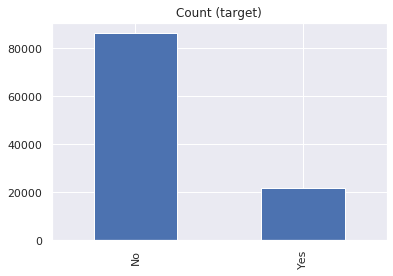

In [0]:
# Quantidade de exemplos positivos e negativos de No-show 0 = a pessoa foi na consulta agenda 1 =  a pessoa não foi na consulta
target_count = dataset['No-show'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [0]:
# Removidas Sexo e Status pois foram criadas apenas para compreender melhor o dataset e No-show foi substituida por Class.
dataset.drop(['No-show','Sexo', 'Status'], inplace=True, axis=1)

In [0]:
dataset.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,WaitingTime,Day,Month,Class,N_AEROPORTO,N_ANDORINHAS,N_ANTÔNIO HONÓRIO,N_ARIOVALDO FAVALESSA,N_BARRO VERMELHO,N_BELA VISTA,N_BENTO FERREIRA,N_BOA VISTA,N_BONFIM,N_CARATOÍRA,N_CENTRO,N_COMDUSA,N_CONQUISTA,N_CONSOLAÇÃO,N_CRUZAMENTO,N_DA PENHA,N_DE LOURDES,N_DO CABRAL,N_DO MOSCOSO,N_DO QUADRO,N_ENSEADA DO SUÁ,N_ESTRELINHA,N_FONTE GRANDE,N_FORTE SÃO JOÃO,N_FRADINHOS,N_GOIABEIRAS,N_GRANDE VITÓRIA,N_GURIGICA,N_HORTO,N_ILHA DAS CAIEIRAS,N_ILHA DE SANTA MARIA,N_ILHA DO BOI,N_ILHA DO FRADE,N_ILHA DO PRÍNCIPE,N_ILHAS OCEÂNICAS DE TRINDADE,N_INHANGUETÁ,N_ITARARÉ,N_JABOUR,N_JARDIM CAMBURI,N_JARDIM DA PENHA,N_JESUS DE NAZARETH,N_JOANA D´ARC,N_JUCUTUQUARA,N_MARIA ORTIZ,N_MARUÍPE,N_MATA DA PRAIA,N_MONTE BELO,N_MORADA DE CAMBURI,N_MÁRIO CYPRESTE,N_NAZARETH,N_NOVA PALESTINA,N_PARQUE INDUSTRIAL,N_PARQUE MOSCOSO,N_PIEDADE,N_PONTAL DE CAMBURI,N_PRAIA DO CANTO,N_PRAIA DO SUÁ,N_REDENÇÃO,N_REPÚBLICA,N_RESISTÊNCIA,N_ROMÃO,N_SANTA CECÍLIA,N_SANTA CLARA,N_SANTA HELENA,N_SANTA LUÍZA,N_SANTA LÚCIA,N_SANTA MARTHA,N_SANTA TEREZA,N_SANTO ANDRÉ,N_SANTO ANTÔNIO,N_SANTOS DUMONT,N_SANTOS REIS,N_SEGURANÇA DO LAR,N_SOLON BORGES,N_SÃO BENEDITO,N_SÃO CRISTÓVÃO,N_SÃO JOSÉ,N_SÃO PEDRO,N_TABUAZEIRO,N_UNIVERSITÁRIO,N_VILA RUBIM
0,0,62,0,1,0,0,0,0,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,0,29,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Dividir o dataset em X e y.
# X variáveis preditoras
# y variável target

X = dataset.drop('Class', axis=1)
y = df_o['Class']       

In [0]:
X.shape

(107853, 92)

In [0]:
# Normalizar os dados
 X = StandardScaler().fit_transform(X)

In [0]:
# Sample Oversampling - a classe menor recebe novos dados sinteticos para alcançar a classe superior
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

In [0]:
y_sm.shape

(172642,)

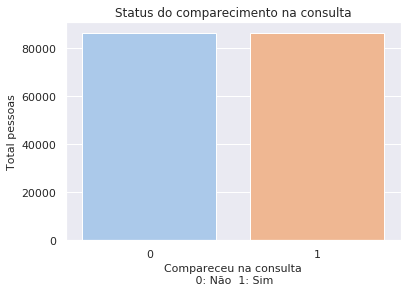

In [0]:
# Dataset após Smote
sns.countplot(y_sm, palette="pastel")
plt.box = False
plt.xlabel('Compareceu na consulta\n 0: Não  1: Sim', fontsize = 11)
plt.ylabel("Total pessoas", fontsize = 11)
plt.title("Status do comparecimento na consulta")
plt.show()

### Modelos


In [0]:
# Divisão dos dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 42)

In [0]:
# Shape dos dados de treinamento
# X_treino

X_treino.shape

(129481, 92)

In [0]:
def rfc_model(X_treino,y_treino, n_estimators =500, cv = 10):
  rfc = RandomForestClassifier(n_estimators= n_estimators, random_state = 42, n_jobs = -1, criterion= 'entropy')
  cv_scores = cross_val_score(rfc, X_treino, y_treino, scoring = 'roc_auc', cv = cv, n_jobs = -1)
  print("Média dos", cv,"testes:", np.round(cv_scores.mean(),4))

In [0]:
def gbc_model (X_treino, y_treino, n_estimators = 500, learning_rate = 0.1, cv = 10):
  gbc = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, random_state = 42 )
  cv_scores = cross_val_score(gbc, X_treino, y_treino, scoring= "roc_auc", cv = cv, n_jobs = -1)
  print("Média dos", cv, "teste:", np.round(cv_scores.mean(),4)) 

## Valor AUC calculado nos modelos

---



In [0]:
rfc_model(X_treino, y_treino)

Média dos 10 testes: 0.929


In [0]:
gbc_model(X_treino, y_treino)

Média dos 10 teste: 0.919


### Curva AUC do melhor modelo

In [0]:
rfc = RandomForestClassifier(n_estimators= 500, random_state = 42, n_jobs = -1, criterion= 'entropy')
rfc.fit(X_treino, y_treino)
prediction = rfc.predict_proba(X_teste)
proba_predict = prediction[:,1] # Coluna de indice 1, corresponde a classe positiva onde a pessoa Não-Compareceu a consulta

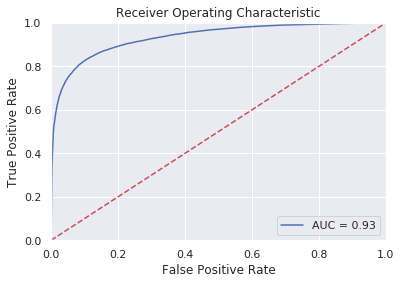

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_teste, proba_predict)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. [source: Wikipedia]

In [0]:
prediction = rfc.predict(X_teste)
matthews_corrcoef(y_teste,prediction)

0.7198847638887395

### Selecionando as variáveis mais importantes


In [0]:
# Modelo com melhor score AUC
# Recriando o modelo pois estava interno a função rfc_model
# Criando o modelo com nome rfc apenas

rfc = RandomForestClassifier(n_estimators= 500, random_state = 42, n_jobs = -1)
rfc.fit(X_treino, y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
importances = rfc.feature_importances_
variables = np.array(dataset.columns)
indices = np.argsort(importances)[::-1]
importances = np.round(importances[indices],4)
variables = variables[indices]

In [0]:
variables

array(['WaitingTime', 'Age', 'Day', 'SMS_received', 'Gender', 'Month',
       'Hipertension', 'Scholarship', 'Diabetes', 'N_CARATOÍRA',
       'N_REPÚBLICA', 'N_JABOUR', 'Handcap', 'N_SÃO JOSÉ', 'N_SÃO PEDRO',
       'N_JUCUTUQUARA', 'Alcoholism', 'N_BOA VISTA', 'N_SANTO ANDRÉ',
       'N_SANTA TEREZA', 'N_RESISTÊNCIA', 'N_SÃO CRISTÓVÃO',
       'N_CRUZAMENTO', 'N_AEROPORTO', 'N_BONFIM', 'N_BARRO VERMELHO',
       'N_JARDIM CAMBURI', 'N_NAZARETH', 'N_INHANGUETÁ', 'N_SANTA LÚCIA',
       'N_FONTE GRANDE', 'N_SÃO BENEDITO', 'N_MARIA ORTIZ',
       'N_GRANDE VITÓRIA', 'N_ILHA DO FRADE', 'N_ITARARÉ',
       'N_JARDIM DA PENHA', 'N_SANTO ANTÔNIO', 'N_PRAIA DO SUÁ',
       'N_HORTO', 'N_ILHA DAS CAIEIRAS', 'N_PRAIA DO CANTO',
       'N_CONSOLAÇÃO', 'N_JESUS DE NAZARETH', 'N_SANTA MARTHA',
       'N_SOLON BORGES', 'N_CONQUISTA', 'N_GOIABEIRAS',
       'N_ILHAS OCEÂNICAS DE TRINDADE', 'N_PARQUE INDUSTRIAL',
       'N_BELA VISTA', 'N_FRADINHOS', 'N_PONTAL DE CAMBURI', 'N_REDENÇÃO',
       'N_DO

In [0]:
variables[2],importances[2]
            

('Day', 0.1851)

In [0]:
def sum_and_plot_importances(variables, importances):
    sum_importances = pd.DataFrame()
    for i in range(importances.size):
        sum_importance = importances[:(i+1)].sum()
        this_variable = pd.Series([variables[i], sum_importance])
        sum_importances = sum_importances.append(this_variable, ignore_index = True)
    plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
    return sum_importances  

### Através desse gráfico é possível ver que rapidamente atingi-se mais de 0.9 na importãncia acumuluada das variáveis. Assim usando apenas a primeiras 10 variáveis já se atinge um valor interessante de performance.


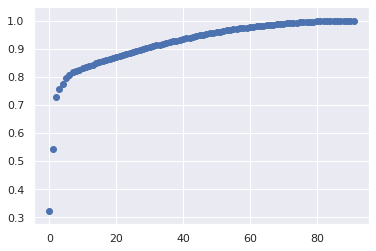

In [0]:
# As primeiras 10 variáveis já atingem um valor acumulado próximo de 1.
sum_importances = sum_and_plot_importances(variables, importances)



### Selecionando apenas as 9 primeiras variáveis no dataset

In [0]:
# Novo dataset com apenas com as principais features
dataset2 = pd.DataFrame()
dataset2[['Class','Gender', 'Age', 'Scholarship', 'Hipertension', 'Handcap', 'SMS_received', 'WaitingTime',
       'Day', 'Diabetes']] = dataset[['Class','Gender', 'Age', 'Scholarship', 'Hipertension', 'Handcap', 'SMS_received', 'WaitingTime',
       'Day', 'Diabetes']]

In [0]:
dataset2.shape

(107853, 10)

In [0]:
# Dividir o dataset em X e y.
# X variáveis preditoras
# y variável target

X = dataset2.drop('Class', axis=1)
y = df_o['Class']

In [0]:
# Normalizar os dados
 X = StandardScaler().fit_transform(X)

In [0]:
# Sample Oversampling - a classe menor recebe novos dados sinteticos para alcançar a classe superior
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

In [0]:
# Divisão dos dados em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 42)

In [0]:
X_treino.shape

(129481, 9)

In [0]:
y_treino.size

129481

### Curva *AUC* com 9 variáveis

In [0]:
rfc = RandomForestClassifier(n_estimators= 500, random_state = 42, n_jobs = -1, criterion= 'entropy')
rfc.fit(X_treino, y_treino)
prediction = rfc.predict_proba(X_teste)

In [0]:
proba_predict = prediction[:,1]

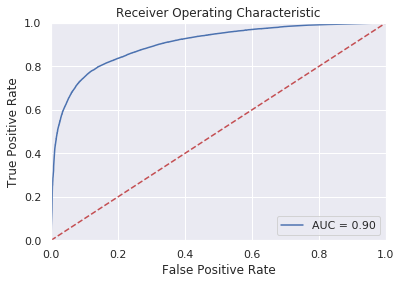

In [0]:
fpr, tpr, threshold = metrics.roc_curve(y_teste, proba_predict)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Avaliação do modelo RFC:
## Submetendo as 92 variáveis o valor AUC foi de 0.93
## Submetendo apenas as 9 variáveis com maior importância para o modelo: 0.90

# *** Quanto maior o valor AUC melhor a performance do modelo.***



### The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient. [source: Wikipedia]

In [0]:
prediction = rfc.predict(X_teste)
matthews_corrcoef(y_teste,prediction)

0.6523742792039626

### O coeficiente de Matthews obtido com as 92 variáveis foi de 0.72.
### O mesmo coeficiente com as 9 variáveis usadas obteve 0.65.